In [1]:
using ForneyLab, Random, Plots, LinearAlgebra
using ForneyLab: unsafeMean

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have Flux in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading Flux into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [2]:
Random.seed!(1234);

In [3]:
text = readlines("SN_y_tot_V2.0.txt") # Data from https://wwwbis.sidc.be/silso/datafiles
dataset = []
for i=246:length(text)-1
    line = text[i]
    spot = Int(round(parse(Float64,split(line)[2])))
    push!(dataset, spot)
end

In [4]:
N = length(dataset);

In [5]:
# Model specification
graph = FactorGraph()

f(z) = z

@RV b ~ Gamma(1000., 1.) # Shape-Rate parameterization in ForneyLab
a = Vector{Variable}(undef, N)
x = Vector{Variable}(undef, N-1)
y = Vector{Variable}(undef, N)
@RV a[1] ~ Gamma(1., b)
@RV y[1] ~ Poisson(a[1])
placeholder(y[1], :y, index=1)

for i=2:N
    @RV x[i-1] ~ Aismp(a[i-1],g=f)
    @RV a[i] ~ Gamma(x[i-1],b)
    @RV y[i] ~ Poisson(a[i]) 
    
    placeholder(y[i], :y, index=i)
end

In [6]:
# Specify factorizations in recognition distribution
pfz = PosteriorFactorization()

q_b = PosteriorFactor(b, id=:b)
q_a = Vector{PosteriorFactor}(undef, N)
for t=1:N
    q_a[t] = PosteriorFactor(a[t],id=:a_*t)
end

algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
code_mf = algorithmSourceCode(algo_mf, free_energy=true);
eval(Meta.parse(code_mf));

In [7]:
n_its = 10
data = Dict(:y => dataset)
marginals = Dict()

marginals[:b] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
for n=1:N
    marginals[:a_*n] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
end
for n=1:N-1
    marginals[:x_*n] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
end

F = []
# Run algorithm
for i = 1:n_its
    stepMFb!(data, marginals)
    for t = 1:N
        step!(:MFa_*t, data, marginals)
    end
    push!(F, freeEnergyMF(data, marginals))
end
;

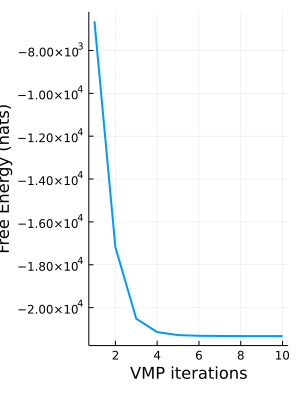

In [8]:
plot(F, legend=false, lw=2,size=(300,400), xlabel="VMP iterations", ylabel="Free Energy (nats)")

In [9]:
mean_list = []
var_list = []
for n=1:N
    push!(mean_list, mean(marginals[:a_*n]))
    push!(var_list, var(marginals[:a_*n]))
end

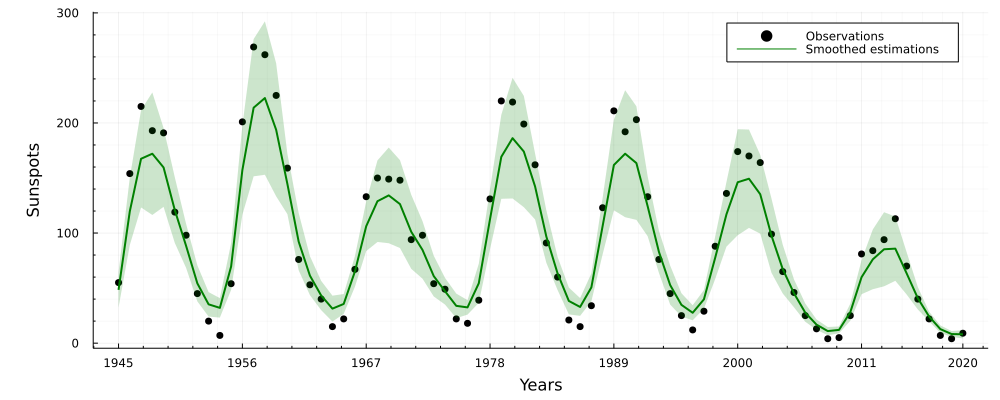

In [10]:
scatter(collect(1:N),dataset,color=:black,size=(900,200),legend=:topright, 
        xtick=([1, 12, 23, 34, 45, 56, 67, 76], [1945, 1956, 1967, 1978, 1989, 2000, 2011, 2020]), 
        xlabel="Years", ylabel="Sunspots", label="Observations", left_margin = 10Plots.mm, bottom_margin = 5Plots.mm)
plot!(mean_list,ribbon=var_list,label="Smoothed estimations", lw=2, size=(1000,400),color=:green,fillalpha=0.2)
xgrid!(minorgrid=:true)
ygrid!(minorgrid=:true)

In [12]:
println(mean_list)

Any[48.39292545326831, 119.71730837321316, 167.47309629594966, 172.06510606123635, 159.58139536124227, 120.75252930936968, 88.37495541208631, 54.3104694496469, 35.24575788579035, 32.046010449454116, 69.60605111581964, 157.24658869154217, 213.86592467245288, 222.63739848837622, 193.79582597462922, 144.50860425155528, 92.20659383551202, 61.30019815622601, 43.260956675117896, 31.341691784822178, 35.59285611573397, 65.17073792470114, 106.19926171993168, 128.92949632445692, 134.2086707657107, 126.29629092145468, 101.13540969305672, 84.68123726040514, 60.8838130787979, 47.161257875787086, 33.867999101265795, 32.47015849512868, 54.374522393024584, 112.72016255961344, 169.23304706327903, 186.20445967608876, 174.04192596159635, 142.3260514045924, 96.83186599709754, 63.291270376285226, 38.30302766153894, 32.85719806278318, 50.628533550652975, 106.29548210217644, 161.8121609854885, 172.06438995095297, 163.54840473486266, 124.36185162762506, 82.94715315066482, 52.741265188769205, 34.78750982068001

In [13]:
println(var_list)

Any[16.01117133232389, 30.575371575587813, 44.26634172701813, 55.63091254283205, 35.78127191212129, 29.802376262570256, 20.00332492287594, 16.37894575240563, 11.099105085312894, 8.856674019638007, 21.269334830981727, 40.60570212065491, 62.32856555600656, 69.68438288475566, 60.40797820772359, 27.37244826674034, 26.017223121251188, 17.722112718791205, 13.299094004380375, 11.774576450502888, 9.028812885362342, 13.92246804104257, 22.580999613191167, 37.058520960120475, 43.4531351952737, 39.91463029740493, 33.656734055119585, 26.143720121734066, 18.5127944511222, 12.118736673375183, 11.14735021230901, 6.571792928572857, 17.75601573739454, 27.241320976478452, 38.12543970167544, 54.80151113097154, 50.555914856773704, 29.968633968129144, 23.81570986007753, 15.061077268113461, 12.198408759406652, 8.071159964039076, 12.679926597734232, 25.6575760433343, 41.14676352804911, 57.68221046450514, 51.58279076994463, 27.23619606561976, 19.110075094950925, 17.70107734864406, 10.575769095447725, 6.8582772